# QRS Complex Dectition Algorithm


## Acquiring the Data

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset with comma as delimiter
df = pd.read_csv("lab5_Philco-L05.txt", delimiter=",")


# # Plot the data
# plt.figure(figsize=(10, 6))
# plt.plot(time, data)
# plt.xlabel('Time')
# plt.ylabel('Data')
# plt.title('ECG Data from Joaquin Philco')
# plt.grid(True)
# plt.show()

df.head()


,sec,CH1,CH40,Unnamed: 3
0,0.000,-0.120850,0.0,NaN
1,0.001,-0.123596,0.0,NaN
2,0.002,-0.126343,0.0,NaN
3,0.003,-0.129395,0.0,NaN
4,0.004,-0.131836,0.0,NaN


## Cleaning the Dataset

In [142]:
# Removing unnecessary columns
df = df.drop('Unnamed: 3', axis=1) # Unnecessary
df = df.drop('CH40', axis=1)

# Only use the first 40,000 entries
df_subset = df.iloc[:40000]

df.head()

,sec,CH1
0,0.000,-0.120850
1,0.001,-0.123596
2,0.002,-0.126343
3,0.003,-0.129395
4,0.004,-0.131836


## Rate of Change Function
This function gets the first and second derivative of the original given signal and adds their absolute components together, to take a look at the rate of change of the data. The QRS component of each beat can be identified by the largest peakls in the plot. 

The function steps:
--> Gets first derivative
--> Gets second derivative
--> Adds absolute values of first and second derivative
--> Transnforms to frequency domain
--> applies a low pass filter to the data
--> return to time domain
--> plots the rate of change
--> returns both x and y components of the rate of change plot

In [143]:
def rate_of_change(signal_x, signal_y):

    # remove dc component
    signal_y = signal_y - np.sum(signal_y)/len(signal_y)

    # Compute the first derivative
    first_derivative = np.gradient(signal_y, signal_x)

    # Compute the second derivative
    second_derivative = np.gradient(first_derivative, signal_x)

    roc_data = abs(first_derivative) + abs(second_derivative)

    # Find the frequency domain components
    fft_result = np.fft.fft(roc_data)

    # Compute the frequencies corresponding to the FFT result
    n = len(roc_data)
    freq = np.fft.fftfreq(n, d=(signal_x[1] - signal_x[0]))

    # Define the cutoff frequency for the low-pass filter
    cutoff_freq = 25  # Adjust this value according to your requirements

    # Create the low-pass filter
    lowpass_filter = np.zeros_like(freq)
    lowpass_filter[np.abs(freq) <= cutoff_freq] = 1

    # Apply the low-pass filter to the FFT result
    filtered_fft_result = fft_result * lowpass_filter

    # Compute the inverse FFT (return to time domain)
    ifft_result = np.fft.ifft(filtered_fft_result)

    # Plot the rate of change plot
    plt.figure(figsize=(10, 6))
    plt.plot(signal_x, np.real(ifft_result))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Rate of Change Plot')
    plt.grid(True)
    plt.show()

    return signal_x, np.real(ifft_result)

## QRS Detection

In [144]:
def qrs_detection(x_data, y_data):
    # Get the maximum and minimum y values
    max_value = np.max(y_data)
    min_value = np.min(y_data)

    # Find the middle y value and use it as threshold
    threshold = (max_value - min_value) / 2

    # Initialize a list to store the new y_data
    y_qrs_detected_binary = []
    x_qrs_detected = []
    y_qrs_detected = []

    # Iterate through data
    for x,y in zip(x_data,y_data):
        if y > threshold:
            y_qrs_detected_binary.append(1)
            y_qrs_detected.append(y)
            x_qrs_detected.append(x)
        else:
            y_qrs_detected_binary.append(0)

    # Plot the values
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, label='QRS Detected', color='blue')
    plt.scatter(x_qrs_detected, y_qrs_detected, color='red', label='Above Threshold')
    plt.xlabel('Time')
    plt.ylabel('QRS Detection')
    plt.title('QRS Detection Result')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_data, y_qrs_detected_binary, y_qrs_detected


## Get More Feature Columns from Dataset

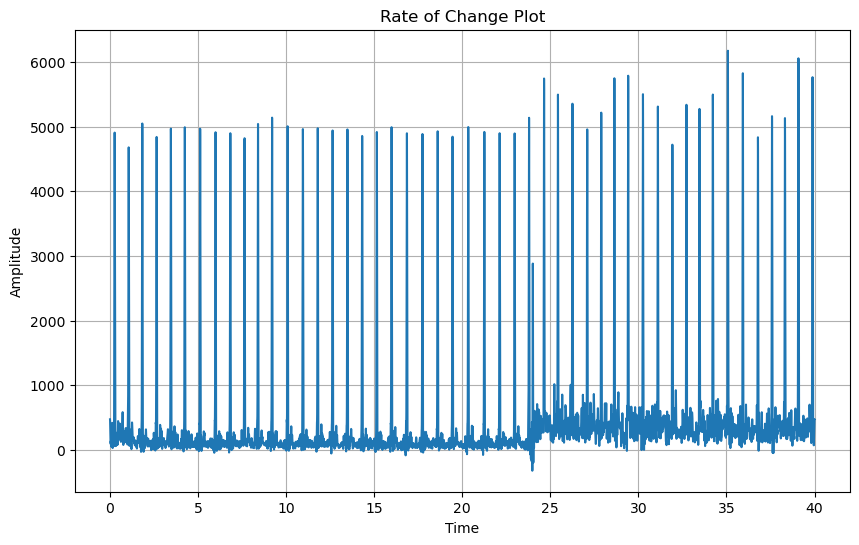

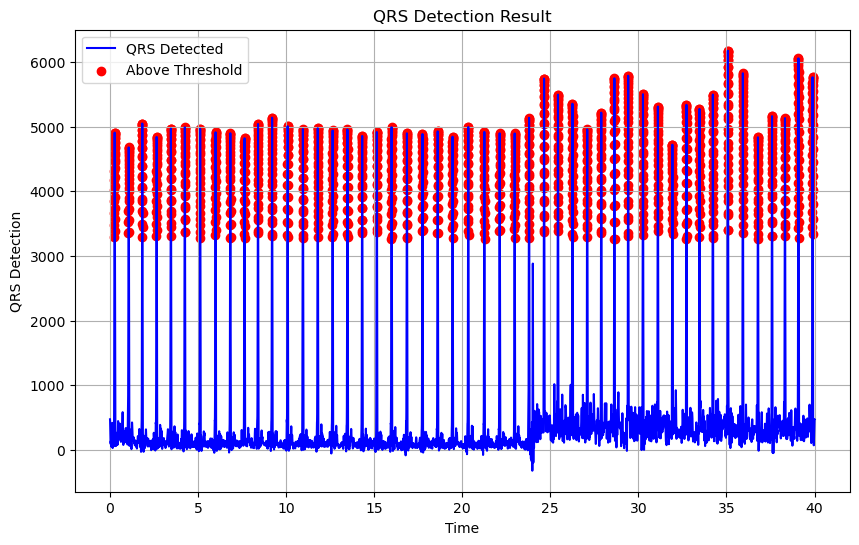

,sec,CH1,Rate_of_change,QRS_detected
0,0.000,-0.120850,473.089494,0.0
1,0.001,-0.123596,470.947881,0.0
2,0.002,-0.126343,467.748027,0.0
3,0.003,-0.129395,463.405971,0.0
4,0.004,-0.131836,457.849716,0.0


In [145]:
# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

[x_data, y_data] = rate_of_change(time[:40000], data[:40000])

# Create a DataFrame for the rate of change
rate_of_change_df = pd.DataFrame({'Rate_of_change': y_data})

# Concatenate the rate of change DataFrame with the original dataset
df = pd.concat([df, rate_of_change_df], axis=1)

df.head()

# Find the QRS Complexes thorugh rate of change
[qrs_x, qrs_y_binary, qrs_y] = qrs_detection(x_data, y_data)

# Add a column to the dataset
qrs_df_binary = pd.DataFrame({'QRS_detected': qrs_y_binary})

# Add it to the dataset 
df = pd.concat([df, qrs_df_binary], axis=1)

df.head()



## Labeling Data for Training

ValueError: x and y must have same first dimension, but have shapes (3000,) and (40000, 2)

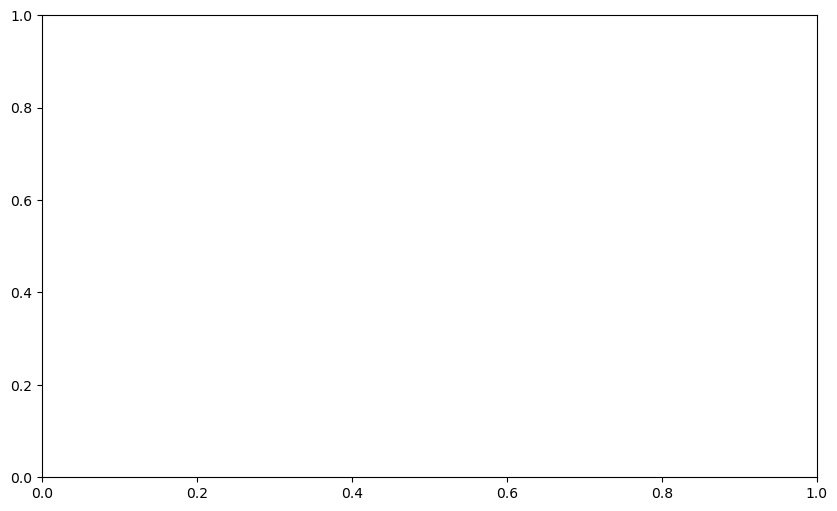

In [146]:
import numpy as np
from scipy.signal import find_peaks


p_indices = [110, 910, 1670, 2490]
q_indices = [219, 1018, 1785, 2605]
r_indices = [257, 1052, 1825, 2641]
s_indices = [284, 1079, 1851, 2663]
t_indices = [460, 1250, 2020, 2840]

# Plot the ECG signal
plt.figure(figsize=(10, 6))
plt.plot(time_subset, df_subset, label='ECG Data')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data from Joaquin Philco')
plt.grid(True)


# Marking P Features
plt.scatter(time_subset[p_indices], df_subset[p_indices], color='black', marker='x', label='P')

# Marking Q Features
plt.scatter(time_subset[q_indices], df_subset[q_indices], color='purple', marker='x', label='Q')

# Marking R Features
plt.scatter(time_subset[r_indices], df_subset[r_indices], color='green', marker='x', label='R')

# Marking S Features
plt.scatter(time_subset[s_indices], df_subset[s_indices], color='red', marker='x', label='S')

# Marking T Features
plt.scatter(time_subset[t_indices], df_subset[t_indices], color='black', marker='x', label='S')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('ECG Data with QRS Features')
plt.legend()
plt.grid(True)
plt.show()
